<a href="https://colab.research.google.com/github/neeluvermaiitj/Introduction-to-Machine-Learning/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Forest

In [ ]:
# Loading the reuired libraries
import pandas as pd
import os
import numpy as np
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree.export import export_text
from sklearn.preprocessing import label_binarize

In [ ]:
# Setting the directory where data resides
location_datasets = '../datasets/'

In [ ]:
# Loading the data
df_input_1 = pd.read_csv(os.path.join(location_datasets, 'wifi_localization.txt'), 
                       sep = "\t", header=None, prefix='col_')

In [ ]:
# Setting the predictor & target variables
X  = df_input_1[df_input_1.columns[:-1]]
y  = df_input_1[df_input_1.columns[-1]]

In [ ]:
# Creating train and test split for model building and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

### Question 1.1

In [ ]:
def compute_entropy(target):
    return sum(target.value_counts(normalize = True).apply(lambda x: -1*x*log2(x)))

def get_best_feature_and_cut_off(df, 
                                 target = 'col_7', 
                                 columns = ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6'], 
                                 process_so_far = ''):
    
    """
    This function gets best feature and cut-off to split the data with an objective of 
    maximizing information gain 
    """
    print('processing subset: {0}'.format(process_so_far))
    
    if df[target].nunique() != 1:
        
        entropy_parent = compute_entropy(df[target])
        best_ig      = 0 
        best_col     = None 
        best_cut_off = None
        best_ent     = None
        for col in columns: 
            for cut_off in df[col].unique(): 
                temp_var = (df[col] <= cut_off).astype('int')
                result = 0
                for value in temp_var.unique():
                    subset = temp_var == value
                    result+=(compute_entropy(df.loc[subset,target])*sum(subset))/df.shape[0]
                current_ig = entropy_parent - result
                if current_ig > best_ig: 
                    best_col = col 
                    best_cut_off = cut_off 
                    best_ig = current_ig
                    best_ent = entropy_parent

        print("Best column is {0} at {1} cut-off. IG is {2} & entropy is {3}".format(best_col, 
                                                                                     best_cut_off, 
                                                                                     best_ig, 
                                                                                     best_ent)) 
        if process_so_far == '':                                                                  
            to_return = ('status: not_complete', 
                         {'best_col': best_col, 
                        'cut_off' : str(best_cut_off), 
                        'left_child'  : "df['{0}'] <={1}".format(best_col, best_cut_off), 
                        'right_child' : "df['{0}'] >{1}".format(best_col, best_cut_off)}, 
                         df[target].mode()[0])
        else:
            to_return = ('status: not_complete', 
                         {'best_col': best_col, 
                        'cut_off' : str(best_cut_off), 
                        'left_child'  :  '(' + process_so_far + ')' + "& (df['{0}'] <={1})".format(best_col, best_cut_off), 
                        'right_child' :  '(' + process_so_far + ')' + "& (df['{0}'] >{1})".format(best_col, best_cut_off) },
                         df[target].mode()[0])
    else: 
        to_return = ('status: complete', process_so_far, df[target].mode()[0])
 
    return to_return

def id3(df = df_input_1, 
        target='col_7', 
        columns = ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6']):
    
    """
    This function implements the ID3 algorithm using the best feature & split mechanism 
    """
    
    to_process = [] 
    outcome = get_best_feature_and_cut_off(df)
    print(outcome)
    to_process.extend([outcome[1]['left_child'], outcome[1]['right_child']])
    
    i = 0
    paths = []
    while len(to_process): 
        #1. subset_data
        #2. get best feature & cutoff 
        #3. Add to process list 
        output = get_best_feature_and_cut_off(df[eval(to_process[i])], process_so_far=to_process[i])
        to_process.remove(to_process[i])
        if output[0] != 'status: complete':
            to_process.extend([output[1]['left_child'], output[1]['right_child']])
            print(output[0])
        else:
            decision_path = {'path': output[1], 'class': output[2]}
            paths.append(decision_path) 
            
        print("The length of process list is:" + str(len(to_process)))
        #print(to_process)
    print('completed creating the decision tree')
    return paths

def score(model_obj, df): 
    df['predicted_class'] = ''
    for decison in model_obj:
        df.loc[eval(decison['path']),'predicted_class'] = decison['class']
    return df

In [ ]:
# Function to pretty print confusion matrix
# Credit : Shay Palachy
# Source : https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

import seaborn as sns
import matplotlib.pyplot as plt

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

In [ ]:
def create_multiclass_roc(actual, predicted, classes, split=''):
    y_true_binarized = label_binarize(actual, classes=class_names)
    y_pred_proba     = predicted

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred_proba.ravel())
    roc_auc     = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(split + ': Receiver operating characteristic (Micro)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
d_tree = id3(df=pd.concat([X_train, y_train], axis = 1))

processing subset: 
Best column is col_0 at -55 cut-off. IG is 0.9386982912284412 & entropy is 1.9995325080341935
('status: not_complete', {'best_col': 'col_0', 'cut_off': '-55', 'left_child': "df['col_0'] <=-55", 'right_child': "df['col_0'] >-55"}, 3)
processing subset: df['col_0'] <=-55
Best column is col_4 at -60 cut-off. IG is 0.9536659949876627 & entropy is 1.0873538576556094
status: not_complete
The length of process list is:3
processing subset: df['col_0'] >-55
Best column is col_0 at -45 cut-off. IG is 0.7079033474323736 & entropy is 1.0351351555602508
status: not_complete
The length of process list is:4
processing subset: (df['col_0'] <=-55)& (df['col_4'] <=-60)
Best column is col_3 at -56 cut-off. IG is 0.14048513469693108 & entropy is 0.21090514733961838
status: not_complete
The length of process list is:5
processing subset: (df['col_0'] <=-55)& (df['col_4'] >-60)
Best column is col_4 at -57 cut-off. IG is 0.04065898918848215 & entropy is 0.05256375109324406
status: not_comp

Best column is col_0 at -50 cut-off. IG is 0.169911534864998 & entropy is 0.6789538995185758
status: not_complete
The length of process list is:5
processing subset: ((((((df['col_0'] >-55)& (df['col_0'] <=-45))& (df['col_4'] >-71))& (df['col_4'] <=-54))& (df['col_2'] <=-54))& (df['col_6'] <=-78))& (df['col_4'] >-65)
The length of process list is:4
processing subset: ((((((df['col_0'] >-55)& (df['col_0'] <=-45))& (df['col_4'] >-71))& (df['col_4'] <=-54))& (df['col_2'] <=-54))& (df['col_6'] >-78))& (df['col_1'] <=-55)
Best column is col_3 at -48 cut-off. IG is 0.299896391167891 & entropy is 0.8453509366224364
status: not_complete
The length of process list is:5
processing subset: ((((((df['col_0'] >-55)& (df['col_0'] <=-45))& (df['col_4'] >-71))& (df['col_4'] <=-54))& (df['col_2'] <=-54))& (df['col_6'] >-78))& (df['col_1'] >-55)
The length of process list is:4
processing subset: (((((((df['col_0'] >-55)& (df['col_0'] <=-45))& (df['col_4'] >-71))& (df['col_4'] <=-54))& (df['col_2'] <=-54)

In [ ]:
df_prediction = score(model_obj=d_tree, df=pd.concat([X_test,y_test], axis = 1))

In [ ]:
y_true = df_prediction['col_7']
y_pred = df_prediction['predicted_class']
cf = confusion_matrix(y_true = y_true, y_pred = y_pred)
#pd.crosstab(df_prediction['col_7'], df_prediction['predicted_class']).reset_index()

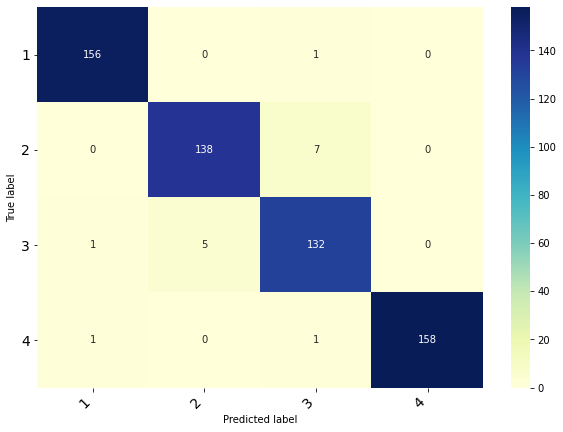

In [ ]:
print_confusion_matrix(cf, class_names=[1,2,3,4])

In [ ]:
print("Accuracy: {0}".format(accuracy_score(y_true=y_true, y_pred=y_pred)))
print("F1-score (micro): {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average="micro")))
print("F1-score (macro): {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average="macro")))
print("F1-score for each class : {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average=None)))

Accuracy: 0.9733333333333334
F1-score (micro): 0.9733333333333334
F1-score (macro): 0.972189193693302
F1-score for each class : [0.99047619 0.95833333 0.94623656 0.99371069]


#### Analysis of model metric 
F1 score is useful when there is class imbalance and we are interested in reduction of false postives & false negatives. Just going by the class balance accuracy is a good enough measure in this scenario

### Question 1.2

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', random_state=42)
clf = clf.fit(X_train, y_train)

In [ ]:
y_true = y_test
y_pred = clf.predict(X_test)

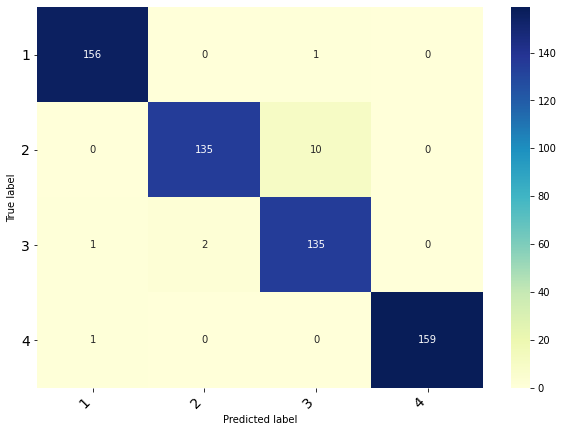

In [ ]:
cf = confusion_matrix(y_true = y_true, y_pred = y_pred)
print_confusion_matrix(cf, class_names=clf.classes_)

In [ ]:
print("Accuracy: {0}".format(accuracy_score(y_true=y_true, y_pred=y_pred)))
print("F1-score (micro): {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average="micro")))
print("F1-score (macro): {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average="macro")))
print("F1-score for each class : {0}".format(f1_score(y_true=y_true, y_pred=y_pred, average=None)))

Accuracy: 0.975
F1-score (micro): 0.975
F1-score (macro): 0.9738731070251743
F1-score for each class : [0.99047619 0.95744681 0.95070423 0.9968652 ]


### Question 1.3

In [ ]:
# we will compare the predictions of both the above models 
df_outcomes = pd.DataFrame({'y_true':y_true, 'ID3':df_prediction['predicted_class'], 'gini':clf.predict(X_test)})

In [ ]:
# Note that there are 9 miss-matches between the both the prediction
len_mm = X_test[df_outcomes['ID3'] != df_outcomes['gini']].shape[0]
df_analysis = df_outcomes[df_outcomes['ID3'] != df_outcomes['gini']]
print(len_mm)

9


##### Comparison of both the measures (Given the prediction from both are not the same)

In [ ]:
print("Correctness of gini: {0}".format((1-sum(df_analysis['y_true'] != df_analysis['gini'])/len_mm)*100))
print("Correctness of ID3: {0}".format((1-sum(df_analysis['y_true'] != df_analysis['ID3'])/len_mm)*100))

Correctness of gini: 55.55555555555556
Correctness of ID3: 44.44444444444444


Overall Gini is slightly better than ID3 when used as impurity metric (see the correctness when prediction in both cases are not the same). ID3 is making mistake in correctly classifying class '3' majority times while gini is incorrectly classifying class '4' out of missmatched predictions between both

### Question 2

In [ ]:
# Loading the data
df_input_2 = pd.read_csv(os.path.join(location_datasets, 'iris.data'), 
                         names = ["sepal length in cm",
                                  "sepal width in cm",
                                  "petal length in cm",
                                  "petal width in cm",
                                  "class"])


Note that the out 12 miss match in prediction by trees by both impurity measure GINI is correct in 58% while ID3 is correct 42% of the times. In absolute terms, gini was correct 2 times in predicting class 2, 4 (combined) when ID3 was incorrect. 

In [ ]:
# Setting the predictor & target variables
X  = df_input_2[df_input_2.columns[:-1]]
y  = df_input_2[df_input_2.columns[-1]]

In [ ]:
# Creating train and test split for model building and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=42)

In [ ]:
clf_dt  = DecisionTreeClassifier(criterion='gini', random_state=42) # we have noticed that gini was slightly better 
clf_rdf = RandomForestClassifier(n_estimators=100, random_state=42)

#Fitting both decision tree and RDF model 
clf_dt.fit(X_train, y_train)
clf_rdf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### 2.1
##### Decision Tree Classifier 

In [ ]:
class_names = clf_dt.classes_
print("Training accuracy: {0}".format(accuracy_score(y_true= y_train, y_pred=clf_dt.predict(X_train))))
print("Testing accuracy: {0}".format(accuracy_score(y_true= y_test, y_pred=clf_dt.predict(X_test))))

Training accuracy: 1.0
Testing accuracy: 0.9666666666666667


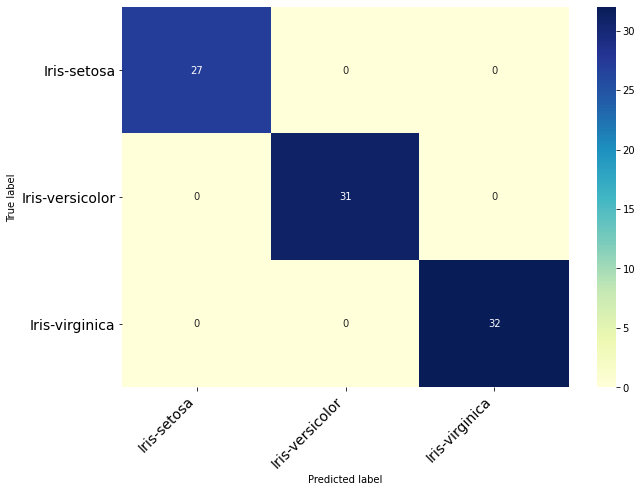

In [ ]:
cf = confusion_matrix(y_true=y_train, y_pred=clf_dt.predict(X_train), labels = class_names)
print_confusion_matrix(cf, class_names=class_names)

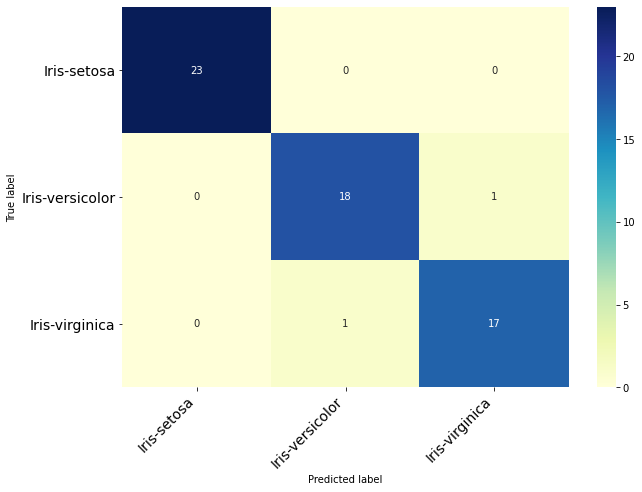

In [ ]:
cf = confusion_matrix(y_true=y_test, y_pred=clf_dt.predict(X_test), labels = class_names)
print_confusion_matrix(cf, class_names=class_names)

In [ ]:
print(classification_report(y_true=y_train, y_pred=clf_dt.predict(X_train), labels=class_names))
# Note - Sensitivity is same as recall

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        27
Iris-versicolor       1.00      1.00      1.00        31
 Iris-virginica       1.00      1.00      1.00        32

       accuracy                           1.00        90
      macro avg       1.00      1.00      1.00        90
   weighted avg       1.00      1.00      1.00        90



In [ ]:
print(classification_report(y_true=y_test, y_pred=clf_dt.predict(X_test), labels=class_names))
# Note - Sensitivity is same as recall

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        23
Iris-versicolor       0.95      0.95      0.95        19
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.97        60
      macro avg       0.96      0.96      0.96        60
   weighted avg       0.97      0.97      0.97        60



In [ ]:
# Train: Recall of negative class is specificity so by the confusion matrix above 
# Iris-versicolor = 1
# Iris-virginica  = 1
# Iris-setosa     = 1

In [ ]:
# Test: Recall of negative class is specificity so by the confusion matrix above 
# Iris-versicolor = 40/41
# Iris-virginica = 41/42
# Iris-setosa = 35/37

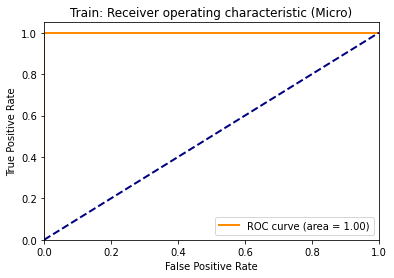

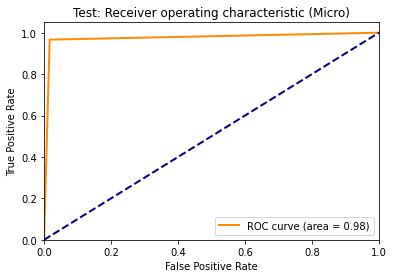

In [ ]:
create_multiclass_roc(actual=y_train, predicted = clf_dt.predict_proba(X_train), classes=class_names, split='Train')
create_multiclass_roc(actual=y_test, predicted = clf_dt.predict_proba(X_test), classes=class_names, split='Test')

##### Random Forest Classifier

In [ ]:
class_names = clf_rdf.classes_

y_pred = clf_rdf.predict(X_train)
y_true = y_train
print("Train Accuracy: {0}".format(accuracy_score(y_true= y_true, y_pred=y_pred)))

y_pred = clf_rdf.predict(X_test)
y_true = y_test
print("Test Accuracy: {0}".format(accuracy_score(y_true= y_true, y_pred=y_pred)))

Train Accuracy: 1.0
Test Accuracy: 0.9833333333333333


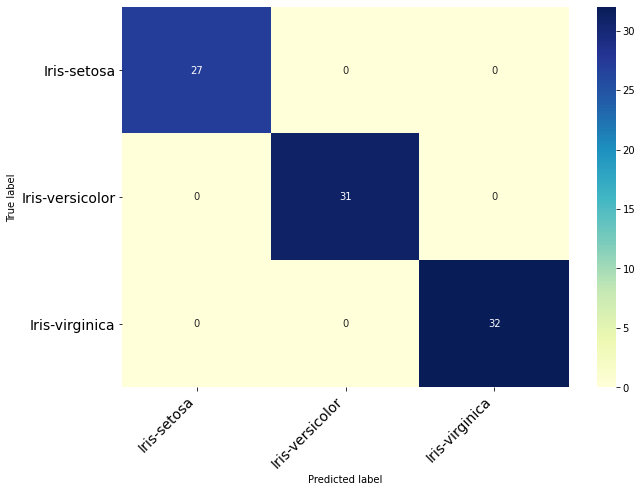

In [ ]:
# Training : Confusion matrix
cf = confusion_matrix(y_true=y_train, y_pred=clf_rdf.predict(X_train), labels = class_names)
print_confusion_matrix(cf, class_names=class_names)

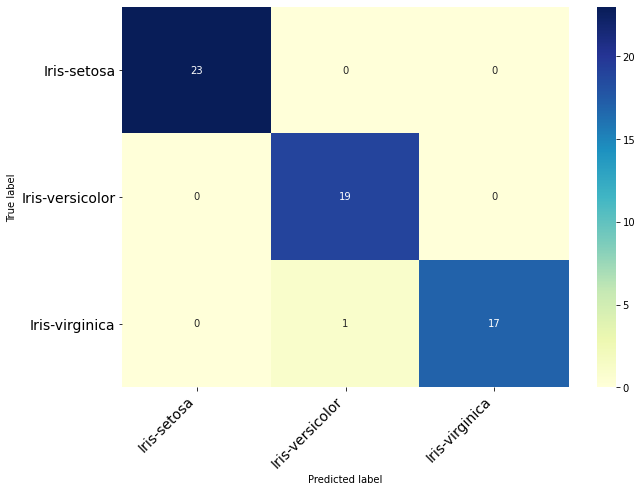

In [ ]:
# Testing : Confusion matrix
cf = confusion_matrix(y_true=y_test, y_pred=clf_rdf.predict(X_test), labels = class_names)
print_confusion_matrix(cf, class_names=class_names)

In [ ]:
# Training classficiation report 
print(classification_report(y_true=y_train, y_pred=clf_rdf.predict(X_train), labels=class_names))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        27
Iris-versicolor       1.00      1.00      1.00        31
 Iris-virginica       1.00      1.00      1.00        32

       accuracy                           1.00        90
      macro avg       1.00      1.00      1.00        90
   weighted avg       1.00      1.00      1.00        90



In [ ]:
print(classification_report(y_true=y_test, y_pred=clf_rdf.predict(X_test), labels=class_names))
# Note - Sensitivity is same as recall

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        23
Iris-versicolor       0.95      1.00      0.97        19
 Iris-virginica       1.00      0.94      0.97        18

       accuracy                           0.98        60
      macro avg       0.98      0.98      0.98        60
   weighted avg       0.98      0.98      0.98        60



In [ ]:
# Train: Recall of negative class is specificity so by the confusion matrix above 
# Iris-versicolor = 1
# Iris-virginica  = 1
# Iris-setosa     = 1

In [ ]:
# Test: Recall of negative class is specificity so by the confusion matrix above 
# Iris-versicolor = 40/41
# Iris-virginica = 42/42
# Iris-setosa = 36/37

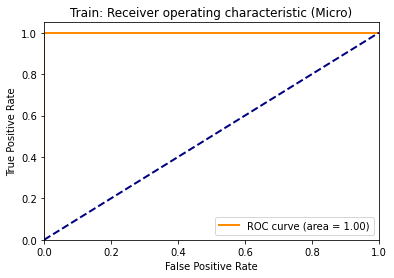

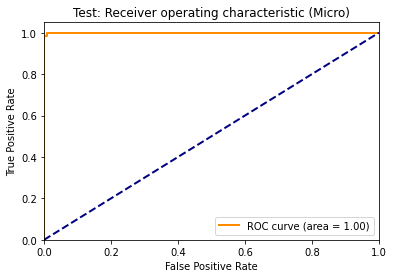

In [ ]:
create_multiclass_roc(actual=y_train, predicted = clf_rdf.predict_proba(X_train), classes=class_names, split='Train')
create_multiclass_roc(actual=y_test, predicted = clf_rdf.predict_proba(X_test), classes=class_names, split='Test')

In [ ]:
r = export_text(clf_dt, feature_names=list(df_input_2.columns.values[:-1]))
print(r)

|--- petal length in cm <= 2.45
|   |--- class: Iris-setosa
|--- petal length in cm >  2.45
|   |--- petal width in cm <= 1.75
|   |   |--- petal length in cm <= 5.35
|   |   |   |--- sepal length in cm <= 4.95
|   |   |   |   |--- sepal width in cm <= 2.45
|   |   |   |   |   |--- class: Iris-versicolor
|   |   |   |   |--- sepal width in cm >  2.45
|   |   |   |   |   |--- class: Iris-virginica
|   |   |   |--- sepal length in cm >  4.95
|   |   |   |   |--- sepal width in cm <= 2.25
|   |   |   |   |   |--- petal width in cm <= 1.25
|   |   |   |   |   |   |--- class: Iris-versicolor
|   |   |   |   |   |--- petal width in cm >  1.25
|   |   |   |   |   |   |--- class: Iris-virginica
|   |   |   |   |--- sepal width in cm >  2.25
|   |   |   |   |   |--- class: Iris-versicolor
|   |   |--- petal length in cm >  5.35
|   |   |   |--- class: Iris-virginica
|   |--- petal width in cm >  1.75
|   |   |--- petal length in cm <= 4.85
|   |   |   |--- sepal width in cm <= 3.10
|   |   |   

#### 2.2

There is no need of hyper parameter tunning as with dataset we have, we are able to perfectly classify using Random forest model. We should use Random Forest model as it gives an AUC of 1 for both training and test data. ROC curve and AUC have for both the algorithms have been shown above